In [ ]:
from pathlib import Path
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random


if 'notebooks' in os.getcwd():
    project_root = Path.cwd().parent
else:
    project_root = Path.cwd()

clusters_dir = project_root / 'data' / 'processed' / 'clusters'



def plot_curves(curves):
    for curve in curves:
        plt.plot(np.arange(0, len(curve), 1.0), curve, label='Reconstructed Series')
    plt.title('Reconstructed Time Series')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.figure(figsize=(12, 10))
    plt.tight_layout()
    plt.show()


def plot_loss_changes(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(gen_losses)+1), gen_losses, label='Generator Loss')
    plt.plot(range(1, len(disc_losses)+1), disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

def scale(dt):
    ma = dt.max().max()
    mi = dt.min().min()
    return ((dt - mi)/(ma-mi)-0.5)*2

days_by_month = {}

def read_month(month):
    file_path = clusters_dir / f"Hours_Of_Day_{month:02d}.json"
    with open(file_path) as f:
        days_by_month[month] = json.load(f)
        days_by_month[month] = {
            key: scale(np.array(value)[:, :])
            for key, value in days_by_month[month].items()
        }

for month in range(1, 13):
    read_month(month)

In [56]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


def generator_loss(fake_output, fake_features, real_features):
    gan_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    feature_loss = tf.reduce_mean(tf.abs(real_features - fake_features))
    lambda_reg = 10.0
    return gan_loss + lambda_reg * feature_loss



class Trainer:
    def __init__(self, cluster, batch_size=32, divider=1):
        self.divider = divider
        self.noise_dim = len(cluster[0])
        self.real_dim = len(cluster[0])
        self.set_max_scaler(cluster)
        self.train_data = tf.data.Dataset.from_tensor_slices(
            cluster).batch(batch_size)
        self.generator_optimizer = tf.keras.optimizers.Adam(
            learning_rate=1e-4, beta_1=0.5, clipnorm=1.0)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(
            learning_rate=1e-4, beta_1=0.5, clipnorm=1.0)
        self.build_generator()
        self.build_discriminator()

    def build_generator(self):
        self.generator = tf.keras.Sequential([
            tf.keras.layers.Dense(256//self.divider, input_dim=self.noise_dim),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            #
            tf.keras.layers.Dense(512//self.divider),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            #
            tf.keras.layers.Dense(1024//self.divider),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            #
            tf.keras.layers.Dense(self.real_dim, activation='tanh')
        ])

    def build_discriminator(self):
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.Dense(1024//self.divider, input_shape=(self.real_dim,)),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dropout(0.1),
            #
            tf.keras.layers.Dense(512//self.divider),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dropout(0.1),
            #
            tf.keras.layers.Dense(256//self.divider),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dropout(0.1),
            #
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    def generate_noise_old(self, batch_size):
        return tf.random.normal([batch_size, self.noise_dim])

    def generate_noise(self, batch_size):
        noise = tf.random.normal([batch_size, self.noise_dim])
        t = tf.linspace(0.0, 4.0 * np.pi, self.noise_dim)  # Create time steps
        sine_wave = tf.sin(self.real_dim/2 * t)  # Sine wave with frequency 24
        sine_wave = tf.reshape(sine_wave, (1, self.noise_dim))  # Reshape for broadcasting
        return noise + sine_wave

    @tf.function
    def train_step(self, real_time_series):
        batch_size = tf.shape(real_time_series)[0]
        noise = self.generate_noise(batch_size)
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate synthetic data
            generated_time_series = self.generator(noise, training=True)
            # Get discriminator outputs
            real_output = self.discriminator(real_time_series, training=True)
            fake_output = self.discriminator(generated_time_series, training=True)
            # Use outputs from the last layer for feature matching
            real_features = self.discriminator(real_time_series, training=False)
            fake_features = self.discriminator(generated_time_series, training=False)
            gen_loss = generator_loss(fake_output, fake_features, real_features)
            disc_loss = discriminator_loss(real_output, fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return gen_loss, disc_loss

    def train(self, epochs):
        gen_losses = []
        disc_losses = []
        for epoch in range(epochs):
            epoch_gen_loss = 0
            epoch_disc_loss = 0
            batches = 0
            for real_time_series in self.train_data:
                g_loss, d_loss = self.train_step(real_time_series)
                epoch_gen_loss += g_loss
                epoch_disc_loss += d_loss
                batches += 1
            avg_gen_loss = epoch_gen_loss / batches
            avg_disc_loss = epoch_disc_loss / batches
            gen_losses.append(avg_gen_loss.numpy())
            disc_losses.append(avg_disc_loss.numpy())
            print(f"Epoch {epoch+1}, Generator Loss: {avg_gen_loss.numpy():.4f}, Discriminator Loss: {avg_disc_loss.numpy():.4f}")
        return gen_losses, disc_losses

    def set_max_scaler(self, cluster):
        self.maximals = [curve.max() for curve in cluster]

    def scaled_generation(self):
        curr_max = self.maximals[random.randint(0, len(self.maximals)-1)]
        noise = self.generate_noise(1)
        generated_sample = self.generator(noise, training=False).numpy().flatten()
        #generated_sample /= generated_sample.max() / curr_max
        return generated_sample

In [57]:
for key in days_by_month[1].keys():
    print(days_by_month[1][key].shape)

(335, 742)
(120, 742)
(110, 742)
(275, 742)
(202, 742)
(335, 742)
(5, 742)
(287, 742)
(12, 742)
(356, 742)
(397, 742)
(15, 742)
(224, 742)
(15, 742)
(123, 742)
(437, 742)
(276, 742)
(122, 742)
(34, 742)
(58, 742)
(319, 742)
(34, 742)
(34, 742)


In [59]:
first = days_by_month[1]['0']
trainer = Trainer(first, 16, 1)
gen_losses, disc_losses = trainer.train(50)

Epoch 1, Generator Loss: 8.4757, Discriminator Loss: 0.6145
Epoch 2, Generator Loss: 11.5587, Discriminator Loss: 0.4067
Epoch 3, Generator Loss: 12.8680, Discriminator Loss: 0.3736
Epoch 4, Generator Loss: 13.1224, Discriminator Loss: 0.3726
Epoch 5, Generator Loss: 12.8938, Discriminator Loss: 0.3964
Epoch 6, Generator Loss: 10.7103, Discriminator Loss: 0.5734
Epoch 7, Generator Loss: 9.8819, Discriminator Loss: 0.6043
Epoch 8, Generator Loss: 6.0426, Discriminator Loss: 1.1726
Epoch 9, Generator Loss: 3.7413, Discriminator Loss: 1.3977
Epoch 10, Generator Loss: 2.2271, Discriminator Loss: 1.3466
Epoch 11, Generator Loss: 1.4407, Discriminator Loss: 1.3992
Epoch 12, Generator Loss: 1.0950, Discriminator Loss: 1.4020
Epoch 13, Generator Loss: 1.0701, Discriminator Loss: 1.4067
Epoch 14, Generator Loss: 0.9992, Discriminator Loss: 1.4173
Epoch 15, Generator Loss: 0.9633, Discriminator Loss: 1.3913
Epoch 16, Generator Loss: 0.9431, Discriminator Loss: 1.3879
Epoch 17, Generator Loss: 0.

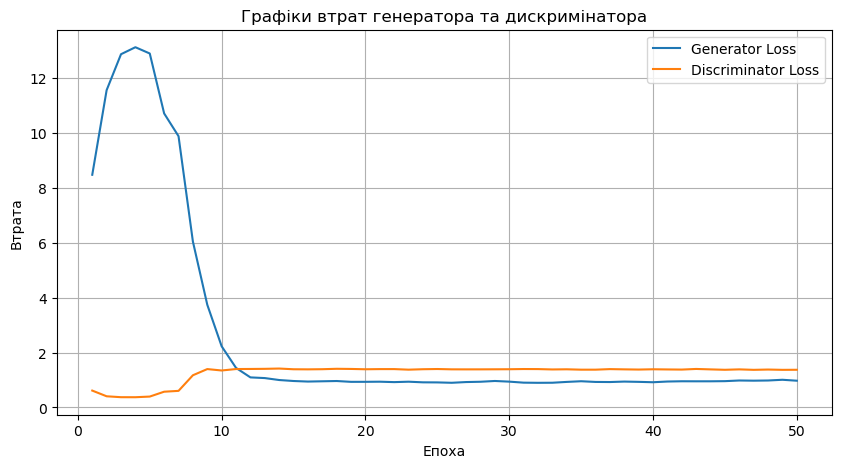

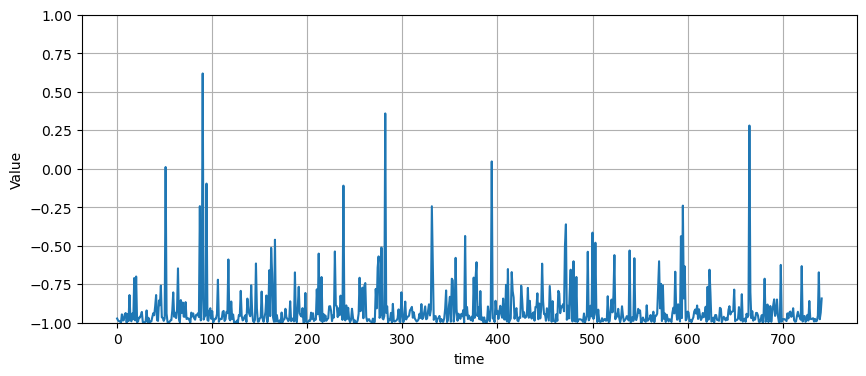

In [60]:
plot_loss_changes(gen_losses, disc_losses)
plt.figure(figsize=(10, 4))
curve = trainer.scaled_generation()
plt.plot(np.arange(0, len(curve), 1.0), curve)
plt.xlabel('time')
plt.ylabel('Value')
plt.ylim(-1, 1)
plt.grid(True)
plt.show()

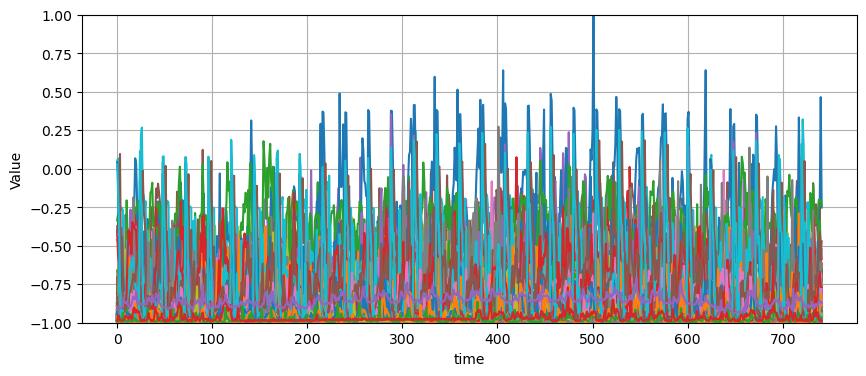

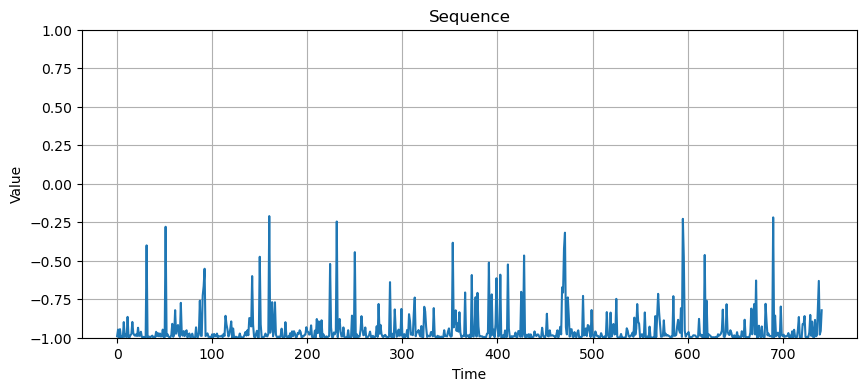

In [61]:
def check_quality(trainer, cluster_key):
    plt.figure(figsize=(10, 4))
    for i in range(len(first)):
        plt.plot(np.arange(0, len(first[i]), 1.0), first[i])
    plt.xlabel('time')
    plt.ylabel('Value')
    plt.ylim(-1, 1)
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 4))
    for i in range(1):
        plt.plot(trainer.scaled_generation())
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.ylim(-1, 1)
    plt.title('Sequence')
    plt.grid(True)
    plt.show()

check_quality(trainer, '0')

In [3]:
class PackTrainer:
    def __init__(self, cluster_pack):
        self.cluster_pack = cluster_pack
        self.trainers = {}
        self.cluster_distribution = {
            key: len(cluster)
            for key, cluster in self.cluster_pack.items()
        }

    def generate_trainers(self, epochs, batch_size=32, divider=1):
        for key, cluster in self.cluster_pack.items():
            self.trainers[key] = Trainer(cluster, batch_size, divider)
            self.trainers[key].train(epochs)

    def generate_dataset(self):
        return {
            key: [
                self.trainers[key].scaled_generation() 
                for _ in range(cluster_num)
            ]
            for key, cluster_num in self.cluster_distribution.items()
        }

    def select_cluster(self):
        keys = list(self.cluster_distribution.keys())
        weights = list(self.cluster_distribution.values())
        return random.choices(keys, weights=weights, k=1)[0]

In [4]:
class SeasonalTrainer:
    def __init__(self, seasonal_cluster_pack):
        self.seasonal_cluster_pack = seasonal_cluster_pack
        self.pack_trainers = {}

    def generate_pack_trainers(self, epochs, batch_size=32, divider=1):
        for season, cluster_pack in self.seasonal_cluster_pack.items():
            self.pack_trainers[season] = PackTrainer(cluster_pack)
            self.pack_trainers[season].generate_trainers(epochs, batch_size, divider)

In [5]:
st = SeasonalTrainer(days_by_month)

In [ ]:
st.generate_pack_trainers(